In [1]:
import sys
import os
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np

# Add project root to path (adjust if needed)
project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

from src.models.image_captioner import ImageCaptioner
from src.models.components.resnet_encoder import ResNet50Encoder
from src.models.components.lstm_decoder import LSTMDecoder

from src.models.components.lstm_decoder import LSTMDecoder
from src.models.components.attention_lstm_decoder import AttentionLSTMDecoder
from src.models.components.attention_gru_decoder import AttentionGRUDecoder
from src.data.vocabulary import Vocabulary
from src.data.flickr_8k_datamodule import Flickr8kDataModule

In [2]:
data_dir = "../data/flickr8k"  # Adjust to your data path

datamodule = Flickr8kDataModule(
    data_dir=data_dir,
    batch_size=32,
    freq_threshold=2,  # Must match your training config
    img_size=224,
)

# Build vocabulary
print("Building vocabulary...")
datamodule.prepare_data()
datamodule.setup(stage="fit")

vocab = datamodule.get_vocab()
vocab_size = datamodule.get_vocab_size()

print(f"✅ Vocabulary loaded: {vocab_size} tokens")
print(f"   PAD: {vocab.pad_idx}, START: {vocab.start_idx}, END: {vocab.end_idx}")

Building vocabulary...
✅ Vocabulary loaded: 4653 tokens
   PAD: 0, START: 1, END: 2


In [3]:
encoder = ResNet50Encoder(
    embed_size=512,
    pretrained=True,
    freeze=True,  # Must match training
)

decoder = AttentionGRUDecoder(
    embed_size=512,
    hidden_size=512,
    vocab_size=vocab_size,
    num_layers=3,
    dropout=0.5,
    attention_dim=512,
)

model = ImageCaptioner(
    encoder=encoder,
    decoder=decoder,
    optimizer=None,  # Not needed for inference
    scheduler=None,
    pad_idx=vocab.pad_idx,
    name="resnet50_lstm",
)

In [4]:
checkpoint_path = (
    "../logs/resnet50_attention_gru/Attention_Gru/checkpoints/epoch_022.ckpt"
)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)

# Load state dict

model.load_state_dict(checkpoint["state_dict"])

# Set to evaluation mode
model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"✅ Checkpoint loaded from: {checkpoint_path}")
print(f"   Epoch: {checkpoint['epoch']}")
print(f"   Global step: {checkpoint['global_step']}")
print(f"   Device: {device}")

✅ Checkpoint loaded from: ../logs/resnet50_attention_gru/Attention_Gru/checkpoints/epoch_022.ckpt
   Epoch: 22
   Global step: 5819
   Device: cuda


In [5]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


In [6]:
def generate_caption_from_path(image_path, method="greedy", max_length=100):
    """
    Generate caption for an image file.

    Args:
        image_path: Path to image file
        method: 'greedy' or 'beam'
        max_length: Maximum caption length

    Returns:
        caption_text: Generated caption as string
        image: PIL Image
    """
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Generate caption
    with torch.no_grad():
        if method == "greedy":
            caption_indices = model.generate_caption(
                image_tensor, vocab, max_length=max_length, method="greedy"
            )[0]
        elif method == "beam":
            caption_indices = model.generate_caption(
                image_tensor, vocab, max_length=max_length, method="beam"
            )[0]
        else:
            raise ValueError(f"Unknown method: {method}")

    # Decode caption
    caption_text = vocab.decode(caption_indices, skip_special_tokens=True)

    return caption_text, image


def display_image_with_caption(image_path, method="greedy"):
    """Display image with generated caption."""
    caption, image = generate_caption_from_path(image_path, method=method)

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Generated Caption ({method}):\n{caption}", fontsize=14, wrap=True)
    plt.tight_layout()
    plt.show()

    return caption



GREEDY SEARCH:


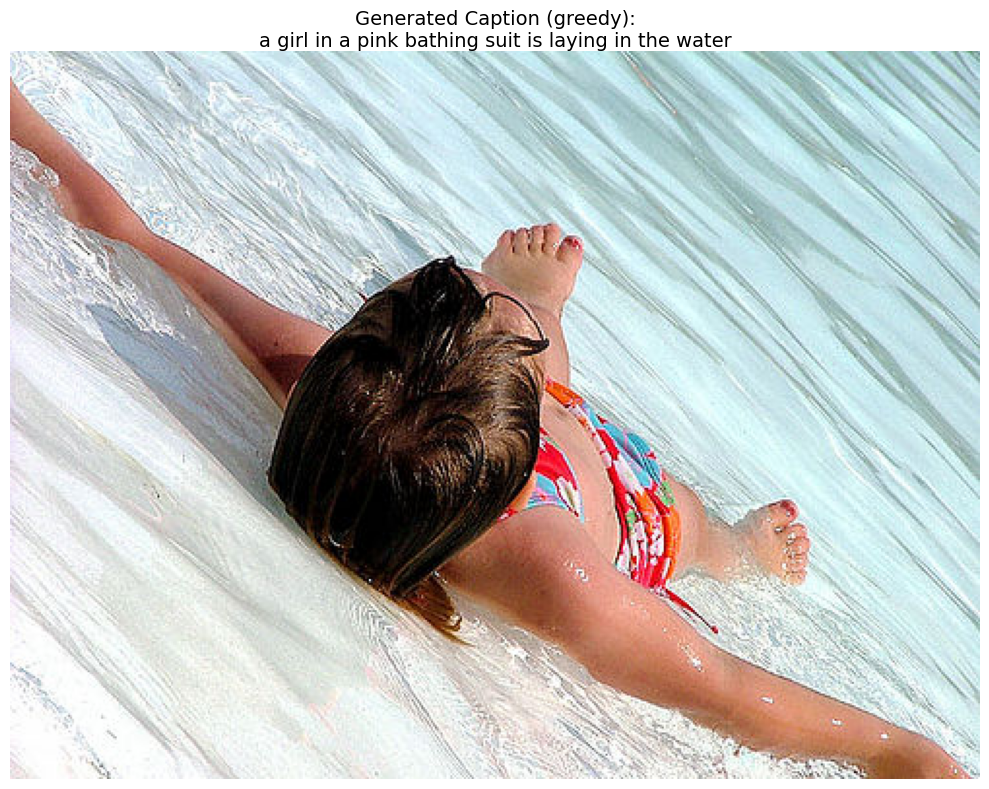

Caption: a girl in a pink bathing suit is laying in the water


In [7]:
test_image_path = "../data/flickr8k/Images/667626_18933d713e.jpg"  # Change this

# Generate with greedy search
print("\n" + "=" * 60)
print("GREEDY SEARCH:")
print("=" * 60)
caption_greedy = display_image_with_caption(test_image_path, method="greedy")
print(f"Caption: {caption_greedy}")

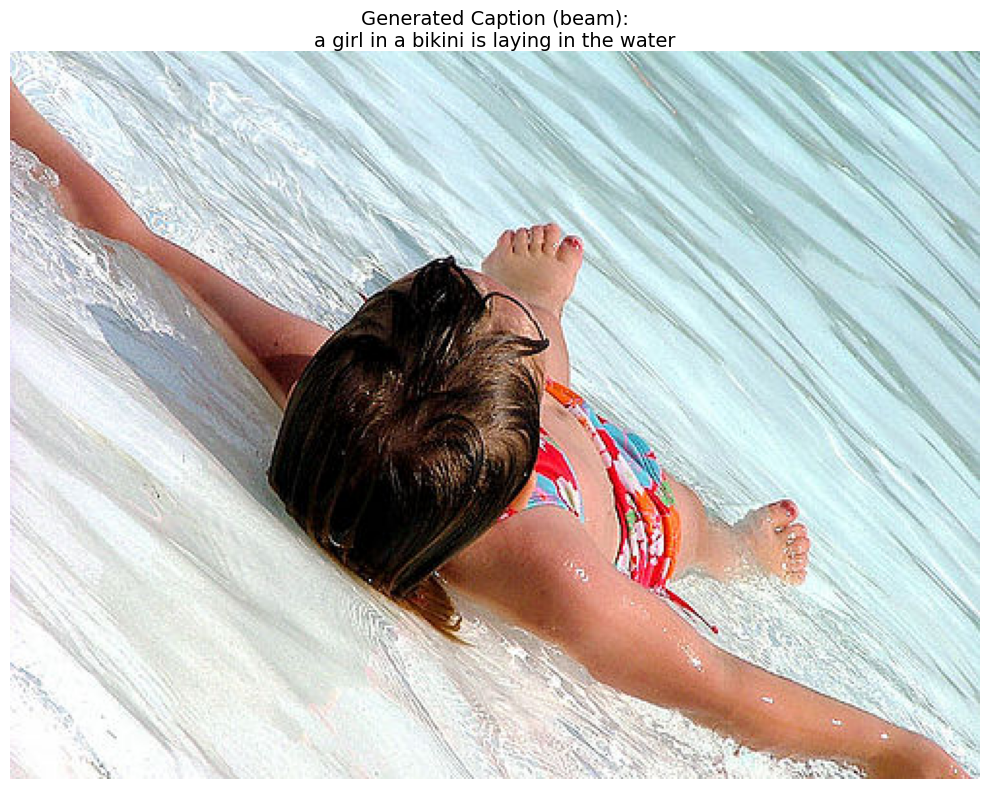

In [8]:
caption_beam = display_image_with_caption(test_image_path, method="beam")


TESTING ON MULTIPLE IMAGES:

[1/5] 3226796100_08c49cfa5c.jpg


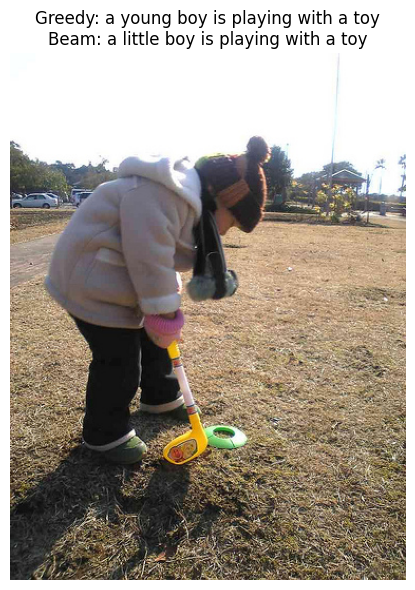

  Greedy: a young boy is playing with a toy
  Beam:   a little boy is playing with a toy

[2/5] 2654514044_a70a6e2c21.jpg


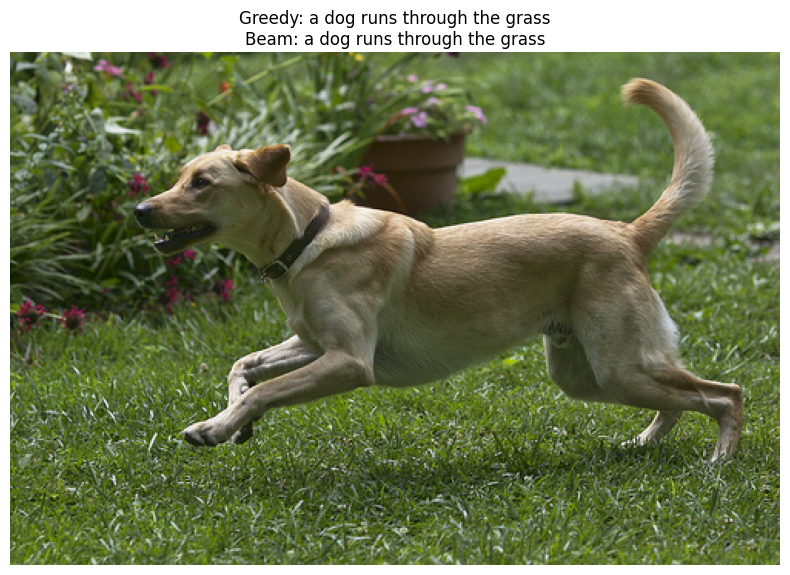

  Greedy: a dog runs through the grass
  Beam:   a dog runs through the grass

[3/5] 1809758121_96026913bb.jpg


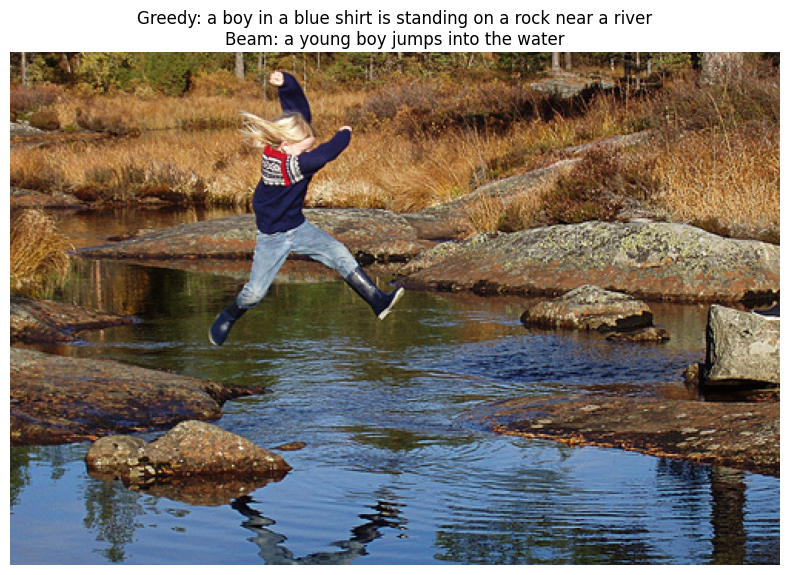

  Greedy: a boy in a blue shirt is standing on a rock near a river
  Beam:   a young boy jumps into the water

[4/5] 3203872773_6c30f64be3.jpg


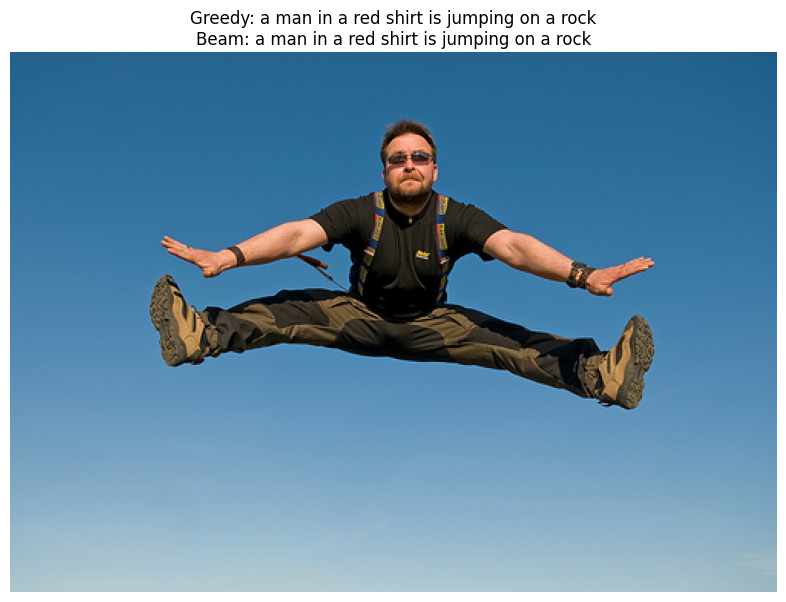

  Greedy: a man in a red shirt is jumping on a rock
  Beam:   a man in a red shirt is jumping on a rock

[5/5] 2695001634_127fe2f0d7.jpg


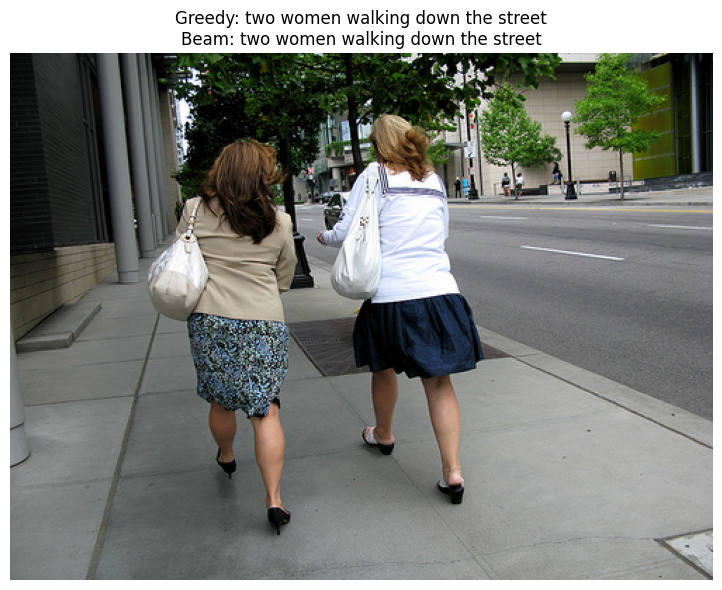

  Greedy: two women walking down the street
  Beam:   two women walking down the street


In [9]:
import glob

# Get some test images
image_dir = "../data/flickr8k/Images"
image_files = glob.glob(os.path.join(image_dir, "*.jpg"))[:5]  # First 5 images

print("\n" + "=" * 60)
print("TESTING ON MULTIPLE IMAGES:")
print("=" * 60)

for i, img_path in enumerate(image_files, 1):
    print(f"\n[{i}/{len(image_files)}] {os.path.basename(img_path)}")

    caption_greedy, image = generate_caption_from_path(img_path, method="greedy")
    caption_beam, _ = generate_caption_from_path(img_path, method="beam")

    # Display
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Greedy: {caption_greedy}\nBeam: {caption_beam}", fontsize=12)
    plt.tight_layout()
    plt.show()

    print(f"  Greedy: {caption_greedy}")
    print(f"  Beam:   {caption_beam}")



Testing on: ../data/custom_img.png


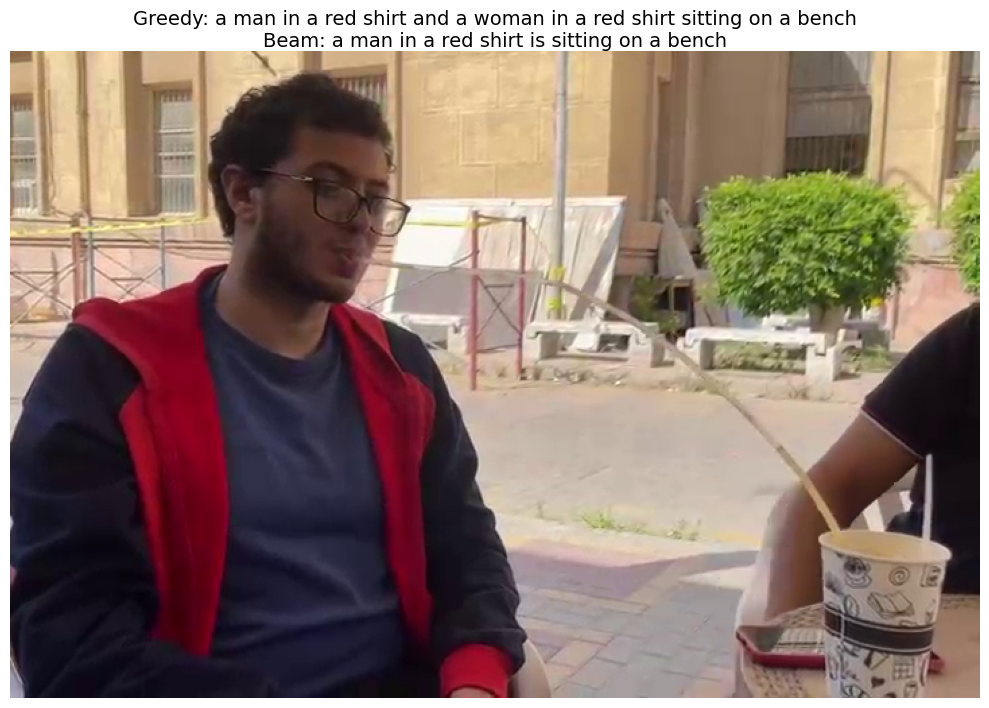

Greedy: a man in a red shirt and a woman in a red shirt sitting on a bench
Beam:   a man in a red shirt is sitting on a bench


('a man in a red shirt and a woman in a red shirt sitting on a bench',
 'a man in a red shirt is sitting on a bench')

In [10]:
def test_custom_image(image_path):
    """Test on any custom image."""
    print(f"\nTesting on: {image_path}")

    # Generate captions
    caption_greedy, image = generate_caption_from_path(image_path, method="greedy")
    caption_beam, _ = generate_caption_from_path(image_path, method="beam")

    # Display
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(
        f"Greedy: {caption_greedy}\nBeam: {caption_beam}", fontsize=14, wrap=True
    )
    plt.tight_layout()
    plt.show()

    print(f"Greedy: {caption_greedy}")
    print(f"Beam:   {caption_beam}")

    return caption_greedy, caption_beam


custom_image = "../data/custom_img.png"
test_custom_image(custom_image)

In [11]:
# %%
from torchmetrics.text.bleu import BLEUScore
from tqdm import tqdm


def evaluate_all_bleu(model, dataloader, vocab, device, method="greedy"):
    model.eval()

    # Initialize scorers for 1-gram through 4-gram
    # We use 'average=None' or multiple scorers to see individual progress
    scorers = {
        "BLEU-1": BLEUScore(n_gram=1),
        "BLEU-2": BLEUScore(n_gram=2),
        "BLEU-3": BLEUScore(n_gram=3),
        "BLEU-4": BLEUScore(n_gram=4),
    }

    references = []
    predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Using index to avoid unpacking errors
            images = batch[0].to(device)
            captions = batch[1]

            caps_indices = model.generate_caption(
                images, vocab, max_length=50, method=method
            )

            for idx_list in caps_indices:
                predictions.append(vocab.decode(idx_list, skip_special_tokens=True))

            for i in range(captions.shape[0]):
                if captions.ndim == 3:
                    ref_set = [
                        vocab.decode(r.tolist(), skip_special_tokens=True)
                        for r in captions[i]
                    ]
                else:
                    ref_set = [
                        vocab.decode(captions[i].tolist(), skip_special_tokens=True)
                    ]
                references.append(ref_set)

    # Calculate and print results
    print(f"\n✨ Final Results ({method} Search):")
    print("-" * 30)
    final_scores = {}
    for name, scorer in scorers.items():
        score = scorer(predictions, references)
        final_scores[name] = score.item()
        print(f"{name}: {score.item():.4f}")

    return final_scores


datamodule.setup(stage="test")
test_loader = datamodule.test_dataloader()
test_loader.num_workers = 0

scores = evaluate_all_bleu(model, test_loader, vocab, device, method="greedy")
scores = evaluate_all_bleu(model, test_loader, vocab, device, method="beam")

100%|██████████| 127/127 [01:38<00:00,  1.30it/s]



✨ Final Results (greedy Search):
------------------------------
BLEU-1: 0.3184
BLEU-2: 0.1792
BLEU-3: 0.1061
BLEU-4: 0.0637


100%|██████████| 127/127 [10:50<00:00,  5.13s/it]



✨ Final Results (beam Search):
------------------------------
BLEU-1: 0.3014
BLEU-2: 0.1732
BLEU-3: 0.1050
BLEU-4: 0.0651
